# COGS 189: Final Project
### Members: Ehson Pirouzian, ... write your own

This is our Winter 2022 Final Project for COGS 189
The purpose is a machine learning project that relates to motor sensory data from BCI competition IV dataset 2a

## Hypothesis

ADD which one we think.

Is it easiest to classify data left hand sensory data against right hand, foot, or tounge sensory data?


## Overview 

Our mission is to classify the different motor imageries and see which classification has the best accuracy for classification and which comparison has the best accuracy.

1. We begin by importing the data and wrangling it to fit our standard for EEG.

2. Then we filter and epoch the data.

3. And lastly run it through our pipelines to see what the results yield.


## Importing the data

Below is the section where we import the necessary python imports and our data file from gdf.

In [745]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
import scipy.io as sio
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [746]:
# Import the raw file using mne
raw = mne.io.read_raw_gdf('./BCICIV_2a_gdf/A01T.gdf', preload=True)
raw2 = mne.io.read_raw_gdf('./BCICIV_2a_gdf/A02T.gdf', preload=True)
raw3 = mne.io.read_raw_gdf('./BCICIV_2a_gdf/A03T.gdf', preload=True)

raw.append(raw2)
raw.append(raw3)

# set channel names to a standard
eegbci.standardize(raw) 

Extracting EDF parameters from /Users/ehson/Documents/Classes/COGS189/Cogs-189-Project/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Users/ehson/miniconda3/envs/cogs/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/ehson/miniconda3/envs/cogs/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Effective window size : 8.192 (s)


/var/folders/vm/4clncyz129b_xbn8m9snhw780000gn/T/ipykernel_98104/2382775280.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


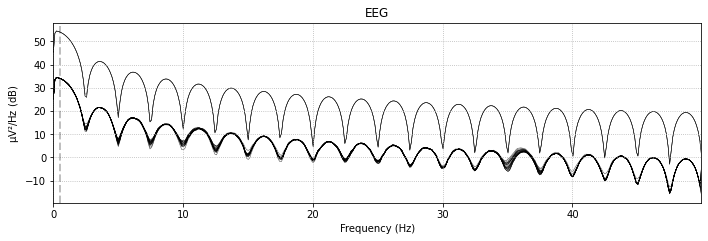

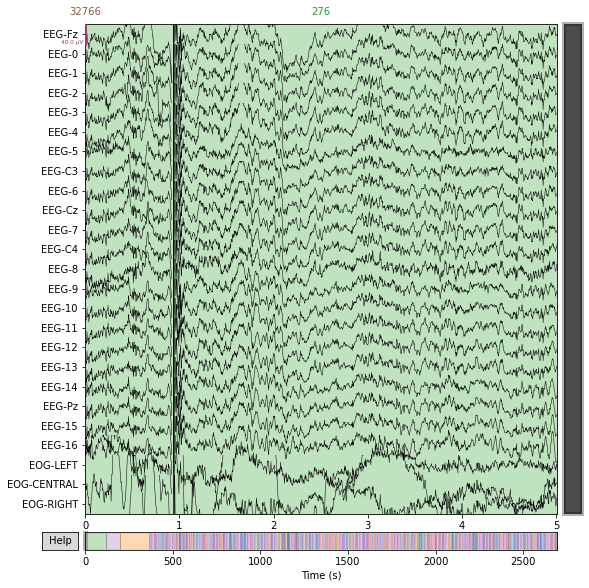

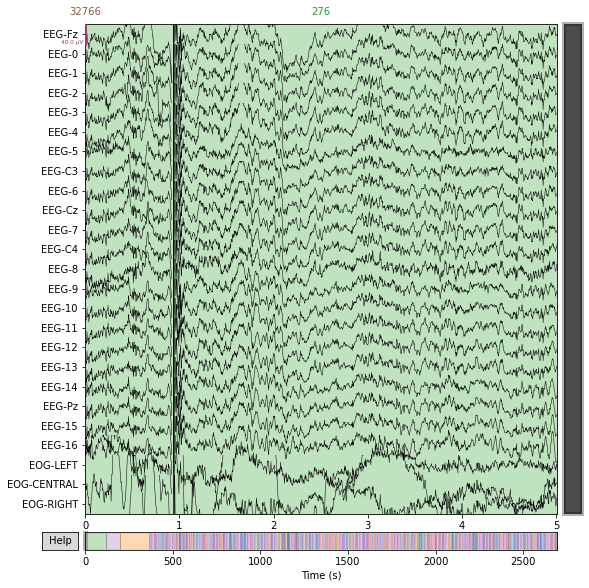

In [747]:
# In order to see the data that we imported and see what the data has
# And we will see each individual channel
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

## Wrangling the data, and filtering

In this section we will both filter our channels and edit our data 

In [748]:
# Rename channels to work with teh montage standard
raw.rename_channels(lambda x: x.strip('EEG-'))
montage = mne.channels.make_standard_montage('standard_1005')

# Set our montage to our raw
raw.set_montage(montage, on_missing='ignore')

# We are excluding the nodes that we find to not be helpful
# We are exclusively looking at nodes in the somato sensory cortex
# So we only keep 4 of the channels.
excludeList = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 
'12', '13', '14', '15', '16', 'OG-LEFT', 'OG-CENTRAL', 'OG-RIGHT', 'OG-1', 'OG-2', 'OG-3', 'Fz']

# Setting up band pass filter which will filter from 8 to 30
raw.filter(8., 30., fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

In [749]:
# Below we will see the data that corresponds to the event type listed
mne.events_from_annotations(raw)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(array([[     0,      0,      5],
        [     0,      0,      3],
        [ 29683,      0,      5],
        ...,
        [670550,      0,      6],
        [670550,      0,      1],
        [671050,      0,      7]]),
 {'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10})

In [750]:
# Define the different functions to seperate our classes
# They all seperate out from left hand
def filterEventsFoot(events):
    finalArray = []
    for event in events:
        if event[2] == 7 or event[2] == 9:
            finalArray.append(event)
    return finalArray

def filterEventsRight_Hand(events):
    finalArray = []
    for event in events:
        if event[2] == 7 or event[2] == 8:
            finalArray.append(event)
    return finalArray

def filterEventsTongue(events):
    finalArray = []
    for event in events:
        if event[2] == 7 or event[2] == 10:
            finalArray.append(event)
    return finalArray

## Left Hand vs Right Hand

The portion of code below will work with classifying the differece between right hand and left hand

In [751]:
# grab the events and change it to be only left and right hand
events, _ = events_from_annotations(raw)
events = filterEventsRight_Hand(events)

# Pick the channels we want Cz C3 C4 and Pz as its along the somatosensory cortex.
# Excludelist was written in data Wrangling. defines the EEG channels we dont want
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude=excludeList)

# set our events and epoch the data
event_id = dict(leftHand=7, rightHand=8)
epochs = Epochs(raw, events, event_id, 0, 6, proj=True, picks=picks, baseline=None, preload=True)
print(epochs.get_data().shape)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Loading data for 144 events and 1501 original time points ...
1 bad epochs dropped
(143, 4, 1501)


In [752]:
# the start of the trial happens at time instance 0 which is the cue,
# then at time instance 1 is when motor imagery happens until 3 seconds later when it stops
# is when we will look and train our data
epochs_train = epochs.copy().crop(tmin=1., tmax=4.)

labels = epochs.events[:, -1] - 2


In [753]:
# Split our testing data and training data with a .2 split as instructed to us by our TA
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

# Randomly yielding indicies to split data into tests and train, and 5 interations of that.
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

### CSP with Epoch data

In [754]:
# Using mne to declare our csp, in next code segment will fill it in with epoch data
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

print(epochs.info)

<Info | 8 non-empty values
 bads: []
 ch_names: C3, Cz, C4, Pz
 chs: 4 EEG
 custom_ref_applied: False
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>


Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 4 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e-06 (2.2e-16 eps * 4 dim * 3.3e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.


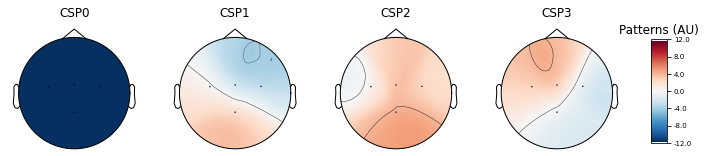

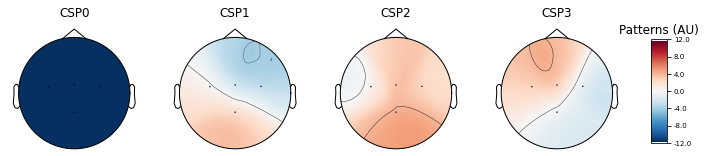

In [755]:
# plot CSP patterns estimated on full data for visualization using our data
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

### Assembling LDA pipline

In [756]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()

# SKlearn Pipeline with csp and lda, evaluating scores using Cross validation
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scoresLDA = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.8e+09  max singular value)
    Estimated rank (mag

In [757]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("LDA accuracy: %f    |    Chance level: %f" % (np.mean(scoresLDA), class_balance))


LDA accuracy: 0.703448    |    Chance level: 0.503497


### Assembling SVM pipline

In [758]:
# Use scikit-learn Pipeline with cross_val_score function
svm = SVC()
clf = Pipeline([('CSP', csp), ('SVM', svm)])
scoresSVC = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.8e+09  max singular value)
    Estimated rank (mag

In [759]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("SVM accuracy: %f    |    Chance level: %f" % (np.mean(scoresSVC), class_balance))


SVM accuracy: 0.648276    |    Chance level: 0.503497


### Assembling KNN pipline

In [760]:
# Use scikit-learn Pipeline with cross_val_score function
knn = KNeighborsClassifier()
clf = Pipeline([('CSP', csp), ('KNN', knn)])
scoresKNN = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.8e+09  max singular value)
    Estimated rank (mag

In [761]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("KNN accuracy: %f    |    Chance level: %f" % (np.mean(scoresKNN), class_balance))

KNN accuracy: 0.613793    |    Chance level: 0.503497


#### Printing our accuracy over time for each pipeline

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.8e+09  max singular value)
    Estimated rank (mag

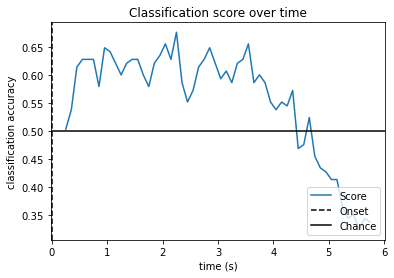

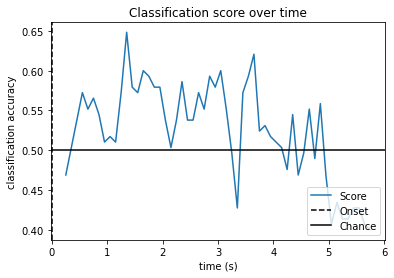

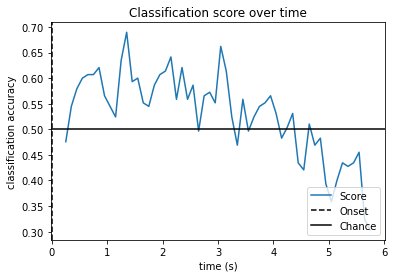

In [762]:
# Modified mne DOCS code to fit our pipelines and to print our accuracy over time.

sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windowsLDA = []
scores_windowsSVM = []
scores_windowsKNN = []


for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_windowLDA = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowLDA.append(lda.score(X_test, y_test))
    scores_windowsLDA.append(score_this_windowLDA)

    svm.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_windowSVM = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowSVM.append(svm.score(X_test, y_test))
    scores_windowsSVM.append(score_this_windowSVM)

    knn.fit(X_train, y_train)
        
    # running classifier: test classifier on sliding window
    score_this_windowKNN = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowKNN.append(knn.score(X_test, y_test))
    scores_windowsKNN.append(score_this_windowKNN)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windowsLDA, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(w_times, np.mean(scores_windowsSVM, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(w_times, np.mean(scores_windowsKNN, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

## Left Hand vs Tounge

The portion of code below will work with classifying the differece between tounge and left hand

In [763]:
# grab the events and change it to be only left and tongue
events, _ = events_from_annotations(raw)
events = filterEventsTongue(events)

# Pick the channels we want Cz C3 C4 and Pz as its along the somatosensory cortex.
# Excludelist was written in data Wrangling. defines the EEG channels we dont want
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude=excludeList)

# set our events and epoch the data
event_id = dict(leftHand=7, tongue=10)
epochs = Epochs(raw, events, event_id, 0, 6, proj=True, picks=picks, baseline=None, preload=True)
print(epochs.get_data().shape)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Loading data for 144 events and 1501 original time points ...
1 bad epochs dropped
(143, 4, 1501)


In [764]:
# the start of the trial happens at time instance 0 which is the cue,
# then at time instance 1 is when motor imagery happens until 3 seconds later when it stops
# is when we will look and train our data
epochs_train = epochs.copy().crop(tmin=1., tmax=4.)

labels = epochs.events[:, -1] - 2

In [765]:
# Split our testing data and training data with a .2 split as instructed to us by our TA
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

# Randomly yielding indicies to split data into tests and train, and 5 interations of that.
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

### CSP with Epoch data

Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 4 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e-06 (2.2e-16 eps * 4 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.


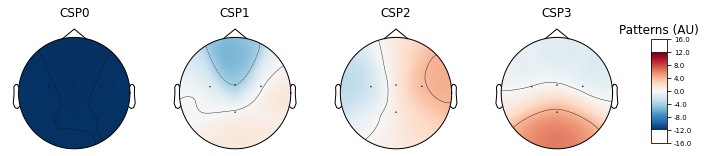

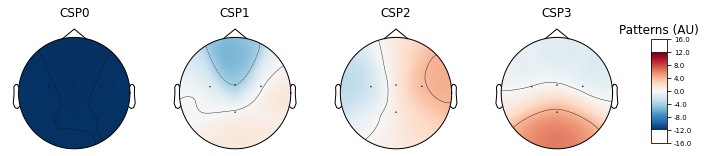

In [766]:
# plot CSP patterns estimated on full data for visualization using our data
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

### Assembling LDA pipline

In [767]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()

# SKlearn Pipeline with csp and lda, evaluating scores using Cross validation
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scoresLDA = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag):

In [768]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("LDA accuracy: %f    |    Chance level: %f" % (np.mean(scoresLDA), class_balance))


LDA accuracy: 0.951724    |    Chance level: 0.503497


### Assembling SVM pipline

In [769]:
# Use scikit-learn Pipeline with cross_val_score function
svm = SVC()
clf = Pipeline([('CSP', csp), ('SVM', svm)])
scoresSVC = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag):

In [770]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("SVM accuracy: %f    |    Chance level: %f" % (np.mean(scoresSVC), class_balance))


SVM accuracy: 0.951724    |    Chance level: 0.503497


### Assembling KNN pipline

In [771]:
# Use scikit-learn Pipeline with cross_val_score function
knn = KNeighborsClassifier()
clf = Pipeline([('CSP', csp), ('KNN', knn)])
scoresKNN = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag):

In [772]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("KNN accuracy: %f    |    Chance level: %f" % (np.mean(scoresKNN), class_balance))

KNN accuracy: 0.958621    |    Chance level: 0.503497


#### Printing our accuracy over time for each pipeline

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag):

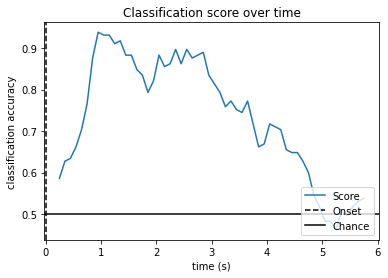

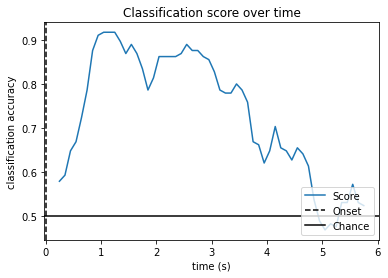

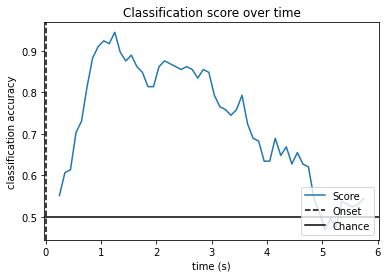

In [773]:
# Modified mne DOCS code to fit our pipelines and to print our accuracy over time.

sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windowsLDA = []
scores_windowsSVM = []
scores_windowsKNN = []


for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_windowLDA = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowLDA.append(lda.score(X_test, y_test))
    scores_windowsLDA.append(score_this_windowLDA)

    svm.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_windowSVM = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowSVM.append(svm.score(X_test, y_test))
    scores_windowsSVM.append(score_this_windowSVM)

    knn.fit(X_train, y_train)
        
    # running classifier: test classifier on sliding window
    score_this_windowKNN = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowKNN.append(knn.score(X_test, y_test))
    scores_windowsKNN.append(score_this_windowKNN)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windowsLDA, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(w_times, np.mean(scores_windowsSVM, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(w_times, np.mean(scores_windowsKNN, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

## Left Hand vs Foot

The portion of code below will work with classifying the differece between foot and left hand

In [774]:
# grab the events and change it to be only left and foot
events, _ = events_from_annotations(raw)
events = filterEventsFoot(events)

# Pick the channels we want Cz C3 C4 and Pz as its along the somatosensory cortex.
# Excludelist was written in data Wrangling. defines the EEG channels we dont want
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude=excludeList)

# set our events and epoch the data
event_id = dict(leftHand=7, foot=9)
epochs = Epochs(raw, events, event_id, 0, 6, proj=True, picks=picks, baseline=None, preload=True)
print(epochs.get_data().shape)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Loading data for 144 events and 1501 original time points ...
1 bad epochs dropped
(143, 4, 1501)


In [775]:
# the start of the trial happens at time instance 0 which is the cue,
# then at time instance 1 is when motor imagery happens until 3 seconds later when it stops
# is when we will look and train our data
epochs_train = epochs.copy().crop(tmin=1., tmax=4.)

labels = epochs.events[:, -1] - 2

In [776]:
# Split our testing data and training data with a .2 split as instructed to us by our TA
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

# Randomly yielding indicies to split data into tests and train, and 5 interations of that.
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

### CSP with Epoch data

Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 4 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-06 (2.2e-16 eps * 4 dim * 6.2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.


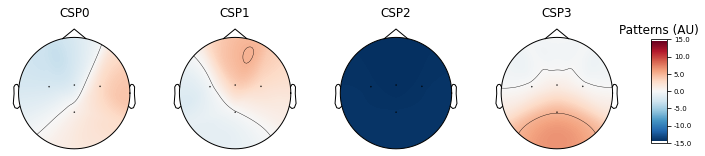

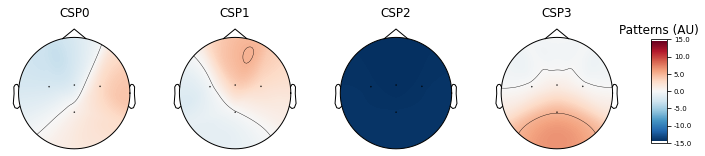

In [777]:
# plot CSP patterns estimated on full data for visualization using our data
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

### Assembling LDA pipline

In [778]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()

# SKlearn Pipeline with csp and lda, evaluating scores using Cross validation
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scoresLDA = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag

In [779]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("LDA accuracy: %f    |    Chance level: %f" % (np.mean(scoresLDA), class_balance))


LDA accuracy: 0.910345    |    Chance level: 0.503497


### Assembling SVM pipline

In [780]:
# Use scikit-learn Pipeline with cross_val_score function
svm = SVC()
clf = Pipeline([('CSP', csp), ('SVM', svm)])
scoresSVC = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag

In [781]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("SVM accuracy: %f    |    Chance level: %f" % (np.mean(scoresSVC), class_balance))


SVM accuracy: 0.889655    |    Chance level: 0.503497


### Assembling KNN pipline

In [782]:
# Use scikit-learn Pipeline with cross_val_score function
knn = KNeighborsClassifier()
clf = Pipeline([('CSP', csp), ('KNN', knn)])
scoresKNN = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag

In [783]:
# Printing the results our scores
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("KNN accuracy: %f    |    Chance level: %f" % (np.mean(scoresKNN), class_balance))

KNN accuracy: 0.896552    |    Chance level: 0.503497


#### Printing our accuracy over time for each pipeline

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 4 dim * 2e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 4 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 4 dim * 2.2e+09  max singular value)
    Estimated rank (mag

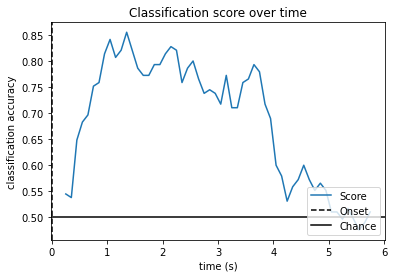

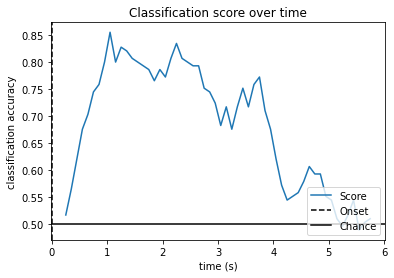

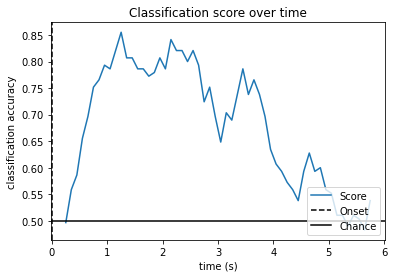

In [784]:
# Modified mne DOCS code to fit our pipelines and to print our accuracy over time.

sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windowsLDA = []
scores_windowsSVM = []
scores_windowsKNN = []


for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_windowLDA = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowLDA.append(lda.score(X_test, y_test))
    scores_windowsLDA.append(score_this_windowLDA)

    svm.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_windowSVM = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowSVM.append(svm.score(X_test, y_test))
    scores_windowsSVM.append(score_this_windowSVM)

    knn.fit(X_train, y_train)
        
    # running classifier: test classifier on sliding window
    score_this_windowKNN = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_windowKNN.append(knn.score(X_test, y_test))
    scores_windowsKNN.append(score_this_windowKNN)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windowsLDA, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(w_times, np.mean(scores_windowsSVM, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.plot(w_times, np.mean(scores_windowsKNN, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()